In [76]:
reset -f

In [77]:
import torch
import torch.nn as nn

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt 

import glob

import os

In [78]:
torch.manual_seed(1234)
np.random.seed(1234)

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Working on {device}")

Working on cpu


In [80]:
'''  
                                                            !!!
    
    The data can grow in number CONSIDERABLY if one considers all the observations of one night and creates triplets by randomly selecting them in this way:
    following the chronological time of observation, after 3 of them have been achieved, one can combine randomly the observations happened
    after the 3rd one with the first ones (NOT EXCLUSIVE), thus creating triplets of observations relatively close in time.
    Repeating this procedure for all the nights is possible to end up with multiples entries from each night.
    
                                                            !!!
'''  

columns_input  = ['alpha','delta','alpha_dot','delta_dot']
columns_output = ['rho','rho_dot']

def load_observations(prefix, input_names = columns_input, output_names = columns_output):
    
    ar_files = sorted(glob.glob(f"{'datas_orbfit'}/{prefix}_N*.ar_sample"))
    
    t_list, X_list, Y_list = [], [], []

    for ar in ar_files:
        # read attributable line
        df_in = pd.read_csv(ar, sep='=', header=None, skiprows=1, nrows=1, names=['tag','values'], engine='python')
        attrib = [float(x) for x in df_in.loc[0,'values'].split()]
        s_attrib = pd.Series(attrib, index=columns_input)

        # read first data row (rho, rho_dot)
        df_out = pd.read_csv(ar, comment='%', sep='\s+', skiprows= 8, nrows = 1, names=['i','j','rho','rho_dot','cc','succ','chi','Jac','E_Sun','E_Earth','H'], engine='python')
        s_out = df_out.loc[0, columns_output]

        # read epoch from mov_sample
        mov = ar.replace('.ar_sample', '.mov_sample')
        df_t = pd.read_csv(mov, sep='=', header=None, skiprows=1, nrows=1, names=['tag','epoch_str'], engine='python')
        epoch = float(df_t.loc[0,'epoch_str'].split()[0])
        
        t_list.append(epoch)
        X_list.append(s_attrib.values)
        Y_list.append(s_out.values)

    return torch.tensor(t_list), torch.tensor(X_list), torch.tensor(Y_list)

In [81]:
# Gravitational constant for the Sun 
#mu = np.power(0.01720209895, 2) #([AU]^3/[day]^2)
mu = 398600.4418 #([km]^3/[s]^2)

#Characteristics quantities of the system
AU =  149597870.7 # km in Au
day = 60*60*24 # s in day
L_c = 3.844e5 # (km) mean orbital radius of the moon
T_c = np.sqrt(np.power(L_c, 3) / mu) # (seconds) orbital period of the moon (2.361e6 [s]) 
V_c = L_c / T_c # (km/s) characteristic velocity

t_0 = torch.tensor([57291.95817]).float().to(device) # t0 for 2015RN35

# Solve Kepler's equation for elliptic orbits using Newton-Raphson iterations
def solve_kepler(M, e, tol=1e-10, maxiter=10):
    E = M.copy()
    for _ in range(maxiter):
        f  = E - e * np.sin(E) - M
        fp = 1 - e * np.cos(E)
        dE = -f / fp
        E += dE
        if np.all(np.abs(dE) < tol):
            break
    return E

def equinoctial_to_cartesian(equin_coord):  #(a, h, k, p, q, L) --> (r; v)
    
    e = np.sqrt(equin_coord[1]**2 + equin_coord[2]**2)
    omega_plus_Omega = np.arctan2(equin_coord[1], equin_coord[2])

    i = 2 * np.arctan(np.sqrt(equin_coord[3]**2 + equin_coord[4]**2))
    Omega = np.arctan2(equin_coord[3], equin_coord[4])

    M = equin_coord[5] - omega_plus_Omega
    M = np.mod(M, 2*np.pi)
    E = solve_kepler(M,e)
   
    nu = 2 * np.arctan2(np.sqrt(1+e)*np.sin(E/2), np.sqrt(1-e)*np.cos(E/2))

    # Perifocal position and velocity
    r_pqw = equin_coord[0] * (1 - e*np.cos(E))
    r_vec_pqw = r_pqw * np.array([np.cos(nu), np.sin(nu), 0])
    v_vec_pqw = np.sqrt(mu * equin_coord[0]) / r_pqw * np.array([-np.sin(E), np.sqrt(1 - e**2)*np.cos(E), 0])

    # Rotation matrices
    cos_Om = np.cos(Omega)
    sin_Om = np.sin(Omega)
    cos_w = np.cos(omega_plus_Omega - Omega)
    sin_w = np.sin(omega_plus_Omega - Omega)
    cos_i = np.cos(i)
    sin_i = np.sin(i)

    # Perifocal to ECI transformation matrix
    R = np.array([
        [cos_Om*cos_w - sin_Om*sin_w*cos_i, -cos_Om*sin_w - sin_Om*cos_w*cos_i, sin_Om*sin_i],
        [sin_Om*cos_w + cos_Om*sin_w*cos_i, -sin_Om*sin_w + cos_Om*cos_w*cos_i, -cos_Om*sin_i],
        [sin_w*sin_i,                        cos_w*sin_i,                       cos_i]
    ])

    # Convert to ECI
    r = R @ r_vec_pqw
    v = R @ v_vec_pqw

    return r, v
    
def equinoctial_to_obs(equin_coord, r_obs=np.zeros(3), v_obs=np.zeros(3)): # here r_obs and v_obs are the coordinates of the observatory

    # Equinoctial → Cartesian
    r_ast, v_ast = equinoctial_to_cartesian(equin_coord)
    
    # Topocentric vectors
    rho_vec = r_ast - r_obs
    v_rel   = v_ast - v_obs

    rho     = np.linalg.norm(rho_vec)
    hat_rho = rho_vec / rho
    rho_dot = hat_rho.dot(v_rel)

    # Compute hat_rho_dot
    rho_hat_dot = (v_rel - rho_dot*hat_rho) / rho

    # Angles
    alpha = np.arctan2(hat_rho[1], hat_rho[0])
    delta = np.arcsin(hat_rho[2])

    # Angular rates
    denom = np.power(hat_rho[0], 2) + np.power(hat_rho[1], 2)
    alpha_dot = (hat_rho[0]*rho_hat_dot[1] - hat_rho[1]*rho_hat_dot[0]) / denom
    delta_dot = rho_hat_dot[2] / np.cos(delta)

    return alpha, delta, alpha_dot, delta_dot, rho, rho_dot

In [82]:
# Functions for data normalization
def normalize(inputs, export_minmax): # from standard to [-1, 1]
    inputs_min = inputs.min(dim=1, keepdim=True).values
    inputs_max = inputs.max(dim=1, keepdim=True).values
    
    if export_minmax == True:
        return 2*(inputs - inputs_min) / (inputs_max - inputs_min + 1e-8) - 1, inputs_min, inputs_max
    else:
        return 2*(inputs - inputs_min) / (inputs_max - inputs_min + 1e-8) - 1

def denormalize(inputs, inputs_min, inputs_max): # from [-1, 1] to standard
    
    return ((inputs + 1)/2)*(inputs_max - inputs_min + 1e-8) + inputs_min

# Funtion for data a-dimensionalization
def non_dimensionalise(x, t, y, t0 = t_0): # x = (alpha, delta, alpha_dot, delta_dot), t = t_obs, y = (rho, rho_dot)
    x_nodim = torch.empty_like(x)
    x_nodim[:,0] = x[:,0] # dimensionless      
    x_nodim[:,1] = x[:,1] # dimensionless               
    x_nodim[:,2] = (x[:,2] / day) * T_c # ([rad/AU] → [rad/s]) → dimensionless                   
    x_nodim[:,3] = (x[:,3] / day) * T_c # ([rad/AU] → [rad/s]) → dimensionless                              
    
    t_mjd = (t - t0) # [s] 
    
    t_nodim = t_mjd / T_c # [s] → dimensionless 

    t_nodim = t_nodim.view(-1, 1)
    
    y_nodim = torch.empty_like(y)
    
    y_nodim[:,0] = (y[:,0] * AU) / L_c # ([AU] → [km]) → dimensionless              
    y_nodim[:,1] = (y[:,1] * (AU/day)) / V_c  # ([AU/day] → [km/s]) → dimensionless  

    x_nodim.requires_grad_(True).float().to(device)
    t_nodim.requires_grad_(True).float().to(device)
    y_nodim.float().to(device)
    
    return x_nodim, t_nodim, y_nodim

In [83]:
# Class to implement a fourier spectral expansion of the inputs (fourier_M = # of frequencies in the spectrum
class FourierEmbedding(nn.Module):
    def __init__(self, in_dim, mapping_size, scale):
        super().__init__()
        self.register_buffer('B', torch.randn(in_dim, mapping_size) * scale)

    def forward(self, x):
        B = self.B.to(x.device).to(x.dtype)
        x_proj = 2 * np.pi * x @ B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [84]:
# Main model
class PINN_VSA(nn.Module):
    
    def __init__(self, layers, loss_type, n_batch, mu, *data, fourier_m = 64, fourier_scale = 10.0): 
        super(PINN_VSA, self).__init__() 
        
        self.fourier = FourierEmbedding(in_dim=5, mapping_size=fourier_m, scale=fourier_scale)

        L0 = 2 * fourier_m # size on input layer is bigger using fourier embedding
        layers = [L0] + layers[1:]
        
        (self.t0, self.x0, self.y0, self.t_domain, self.x_domain, self.y_domain) = data
        self.n_batch = n_batch
        self.losstype = loss_type

        self.mu = mu
        
        #---------------------------------------- Define layers ------------------------------------------
        self.layers = nn.ModuleList()
        self.activation = nn.Tanh() # Activation function
        
        self.s_list = {}
        self.v_list = {}
        biases = []
        mean = 1.0
        std = 0.1
        
        for i in range(len(layers) - 1): 
            
            self.layers.append(nn.Linear(layers[i], layers[i+1], bias = True)) # Fully connected linear layer: the operation [out = w*input + b] will be made by hand with factorized weights
            # Random weight factorization memorization
            
            W = self.layers[-1].weight.detach().clone()  # weights are bot trained but used only now to calculate their factorization
            
            s = torch.exp(torch.randn(layers[i+1])*std + mean)
            v = W / s.unsqueeze(1)

            self.s_list[f"s_{i}"] = nn.Parameter(s, requires_grad = True)
            self.register_parameter(f"s_{i}", self.s_list[f"s_{i}"])  # Register the parameter
            
            self.v_list[f"v_{i}"] = nn.Parameter(v, requires_grad = True)
            self.register_parameter(f"v_{i}", self.v_list[f"v_{i}"]) # Register the parameter
            
            biases.append(self.layers[-1].bias.requires_grad_(True))

            self.layers[i].weight.requires_grad_(False) # we don't need to train these
            self.layers[i].bias.requires_grad_(False) # we have copied the trainable ones in the list "biases" 
            
        self.new_param = list(self.s_list.values()) + list(self.v_list.values()) + biases # new parameters to be trained
        
        #----------------------------------------------------------------------------------------------------------------------------
        self.optimizer = None
        self.train_loss_history = []
        
        #------------------------ For weighted loss procedures and temporal weights -------------------------------------------------
        self.n_losses = 3
        self.loss_weights = torch.ones(self.n_losses, device = device).requires_grad_(False) # Initialize losses weights
        self.f = 50
        self.alpha = 0.9
        self.epsilon = 1.0

    #------------------ Loop operations ---------------------------------------- 
    def get_factorized_weight(self, i):        
        b = self.layers[i].bias

        s = self.s_list[f"s_{i}"]
        v = self.v_list[f"v_{i}"]
        
        return (s.view(-1,1) * v), b
    
        
    def forward(self, X): # Forward pass using random decomposed weights

        X_embed = self.fourier(X)
        a = X_embed.float()
        
        for i in range(len(self.layers) - 1):
            input_copy = a # for skip connections
            
            kernel, b = self.get_factorized_weight(i)
            a = a @ kernel.T + b 
            
            if i < (len(self.layers) - 1):
                a = self.activation(a)

                #Skip connections are activated only after the input layer
                if i >= 1: 
                    if a.shape != input_copy.shape: #In case of layers of different size
                        # Apply a 1x1 linear transformation to match dimensions, but after activation
                        projection = nn.Linear(input_copy.shape[1], a.shape[1], bias=False).to(a.device)
                        input_copy = projection(input_copy) 
                        projection.weight.requires_grad_(False)
                        
                    a = a + input_copy
                     
        kernel, b = self.get_factorized_weight(len(self.layers)-1)
        a = a @ kernel.T + b 
                    
        return a 

    
    def network_prediction(self, t, x):

        return self.forward(torch.cat([t, x], 1))

    # -----------------------------------------------------------------------------
        
    #--------------------------- PDEs ---------------------------------------------
    def get_derivative(self, y, x, n): # General formula to compute the n-th order derivative of y = f(x) with respect to x
        if n == 0:  # (n is the order if the derivative)
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y).to(device), retain_graph=True, allow_unused=True, create_graph=True)[0]
        
        return self.get_derivative(dy_dx, x, n - 1)


    def energy_conservation(self, t, x): # Compute the energy derivative in time
        out = self.network_prediction(t, x) # (rho, rho_dot)
        
        att = torch.cat([x, out], dim=1)
        r, v = self.attributable_to_cartesian(att)
        
        dv_dt = self.get_derivative(v, t, 1)
        
        if dv_dt == None:
            dv_dt = torch.zeros_like(v)
            
        dv_dt.float().to(device)
        
        vr = (v * dv_dt).sum(dim=1)
        rv = (r * v).sum(dim=1)
        rnorm3 = torch.pow(r.norm(dim=1), 3)
            
        f =  vr - self.mu * ( rv / (rnorm3 + 1e-8) ) # v·dv_dt =  mu(r·v/(|r|^(3)))
        
        return f

    '''
    def curvature(self, t, x): #pg. 173 Milani-Gronchi
        out = self.network_prediction(t, x) #(rho, rho_dot)

        att = torch.stack((x[0], x[1], x[2], x[3], out[0], out[1])).detach().numpy()

        r, v = self.attributable_to_cartesian(att.flatten())

        eta = torch.norm(v).requires_grad_(True)
        eta_dot = self.get_derivative(eta, t, 1)

        f = eta_dot - 
    '''
    #-------------------------------------------------------------------------------

    def attributable_to_cartesian(self, att): # (alpha, delta, alpha_dot, delta_dot, rho, rho_dot) --> (r, v)
        # unit line-of-sight
        cd, sd = torch.cos(att[:,1]), torch.sin(att[:,1])
        ca, sa = torch.cos(att[:,0]), torch.sin(att[:,0])
        rho_hat =  torch.stack([cd*ca, cd*sa, sd], dim=1)

        # partials
        d_rho_hat_dalpha = torch.stack([-cd*sa, cd*ca, torch.zeros_like(sd)], dim=1)
        d_rho_hat_ddelta = torch.stack([-sd*ca, -sd*sa, cd], dim=1)

        # time-derivative of rho_hat
        rho_hat_dot = d_rho_hat_dalpha * att[:,2].unsqueeze(1) + d_rho_hat_ddelta * att[:,3].unsqueeze(1)

        # position and velocity
        r = att[:,4].unsqueeze(1) * rho_hat
        v = att[:,5].unsqueeze(1) * rho_hat + att[:,4].unsqueeze(1) * rho_hat_dot

        r.requires_grad_(True).float().to(device)
        v.requires_grad_(True).float().to(device)
        
        return r, v

    #------------------------ Loss and related ------------------------------------
    def loss_IC(self, x, t, y):
        y_pred_IC = self.network_prediction(t, x)
        
        if self.losstype == 'mse':
            loss_IC = torch.mean(torch.pow((y - y_pred_IC),2)).to(device)
            
        elif self.losstype == 'logcosh':
            loss_IC = torch.mean(torch.log(torch.cosh(y - y_pred_IC)))
    
        return loss_IC
        

    def loss_residual(self, x, t, y):
        y_pred = self.network_prediction(t, x)
                
        if self.losstype == 'mse':
            loss_residual = torch.mean(torch.pow((y - y_pred),2)).to(device)
        
        elif self.losstype == 'logcosh':
            loss_residual = torch.mean(torch.log(torch.cosh(y - y_pred))).to(device)

        return loss_residual

    
    def loss_PDE(self, x, t):
        f_pred = self.energy_conservation(t, x)

        f_pred = torch.nan_to_num(f_pred, nan=0.0, posinf=1e3, neginf=-1e3) # clamp out any huge values or NaNs 
        
        if self.losstype == 'mse':
            loss_PDE = torch.mean(torch.pow(f_pred,2)).to(device)
            
        elif self.losstype == 'logcosh':
            loss_PDE = torch.mean(torch.log(torch.cosh(f_pred))).to(device)
                 
        return loss_PDE

    '''
    def forward_temp_weights(self, loss_domain):
        loss_domain = torch.tensor(loss_domain, device=self.temporal_weights.device)
        
        self.temporal_weights = torch.exp(-self.epsilon * torch.cumsum(loss_domain, dim=0))
    '''
    
    def forward_loss_weights(self, losses):       
        losses_tensor = torch.stack(losses)

        parameters = [p for p in self.new_param if p.requires_grad and p.is_leaf] # pick only the parameters that we actually want to differentiate
        
        # Create the gradient of each component of the loss respect to the parameters of the model
        grad_norms = []
        
        for l in losses_tensor: 
            l = l.clone().detach().requires_grad_(True) # make sure this loss is tracked in the current graph
            
            grads = torch.autograd.grad(l, parameters, retain_graph = True, create_graph=True, allow_unused=True)

            flat = []
            for g in grads:
                if g is not None:
                    flat.append(g.view(-1))
            if flat:
                grad_norms.append(torch.norm(torch.cat(flat)))
            else:
                grad_norms.append(torch.tensor(0.0, device=l.device))
            
        grad_norms = torch.stack(grad_norms)

        # Update loss weights
        lambda_hat = grad_norms.sum() / (grad_norms + 1e-8) # ensure lambda is not infinite
        
        self.loss_weights = self.alpha*self.loss_weights.clone() + (1 - self.alpha)*lambda_hat
        
    
    def get_training_history(self):
        loss_his = np.array(self.train_loss_history)
        total_loss, loss_IC, loss_PDE, loss_residual = np.split(loss_his, 4, axis=1) 
        
        return total_loss, loss_IC, loss_PDE, loss_residual

    #--------------------------------------------------------------------------------------------------
    
    def batch_generator(self, x, t, y):   
        #idx = torch.randperm(len(x))
        idx = torch.arange(len(x)) 
    
        # Ensure the batch size is not larger than the available data points
        num_batches = (len(x) + self.n_batch - 1) // self.n_batch  # calculate number of batches
    
        for i in range(num_batches): 
        
            batch_idx = idx[i * self.n_batch : min((i + 1) * self.n_batch, len(x))]  # Get batch indices
        
            batch_x = x[batch_idx]
            batch_t = t[batch_idx]
            batch_y = y[batch_idx]
            
            yield batch_x, batch_t, batch_y
    
    #--------------------------- Training -------------------------------------------------------------
    def train_network(self, epochs, learning_rate, regularization):
        optim = 'Adam'
        #self.optimizer = torch.optim.AdamW(self.new_param, lr = learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=True)
        self.optimizer = torch.optim.Adam(self.new_param, lr = learning_rate, weight_decay = regularization, amsgrad=True) 

        # Learning-rate warmp-up + exponential decay scheduler
        warmup_steps = 600

        warmup_lr = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda = lambda step: min(1.0, (step+1) / warmup_steps)) # lr_Lambda for warmup: lr(t) = [(t / warmup_steps) for t ≤ warmup_steps; 1 afterwards]
        decay_lr = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size = 2000, gamma = 0.90) # exponential decay every step_size steps by factor gamma
        self.scheduler = torch.optim.lr_scheduler.ChainedScheduler([warmup_lr, decay_lr])

        # Training checkpoint 
        self.best_loss = float('inf')
        self.best_model_state = None
        
        # Training loop
        for epoch in range(epochs):
            loss_IC, loss_PDE, loss_residual = 0.0, 0.0, 0.0

            self.optimizer.zero_grad()
            
            # Mini-batch loss for Initial Conditions (IC)
            for batch_x0, batch_t0, batch_y0 in self.batch_generator(self.x0, self.t0, self.y0):  # (arange activated !!)
                loss_IC += self.loss_IC(batch_x0, batch_t0, batch_y0)  
            
            # Mini-batch loss for Domain Loss (PDE) 
            #loss_residual_list = []
            for batch_x_domain, batch_t_domain, batch_y_domain in self.batch_generator(self.x_domain, self.t_domain, self.y_domain): # (arange activated !!)
                loss_PDE += self.loss_PDE(batch_x_domain, batch_t_domain)   
                
                loss_residual += self.loss_residual(batch_x_domain, batch_t_domain, batch_y_domain)
                #loss_residual_list.append(self.loss_residual(batch_x_domain, batch_t_domain, batch_y_domain)) 

            #loss_residual = loss_residual*self.temporal_weights.clone()
            #self.forward_temp_weights(loss_residual_list)
            
            # Give a weights to every singular loss term
            weighted_losses = self.loss_weights.clone()*torch.stack([loss_IC, loss_PDE, loss_residual])
            
            # Total loss for this epoch after having given the weights
            total_loss = weighted_losses.sum()

            '''
            torch.autograd.set_detect_anomaly(True) # DEBUG
            '''
            
            total_loss.backward(retain_graph = True) # always calculate the derivatives first  
            
            if epoch % self.f == 0:
                # Calculate gradients and retain graph in order to derive also all of the singular losses terms for the correspondant global weigth
                self.forward_loss_weights([loss_IC, loss_PDE, loss_residual]) # global weights update routine using the non-weigthed losses

            # Memorize the state of best training (checkpoint!)
            if total_loss.item() < self.best_loss:
                self.best_loss = total_loss.item()
                self.best_model_state = {'model': self.state_dict(),'epoch': epoch}
                
            self.train_loss_history.append([total_loss.cpu().detach(), weighted_losses[0].cpu().detach(), weighted_losses[1].cpu().detach(), weighted_losses[2].cpu().detach()]) 
                
            torch.nn.utils.clip_grad_norm_(self.new_param, max_norm=1.0) # clipping
            
            # Optimize the network parameters            
            self.optimizer.step()
            
            self.scheduler.step()
                
            # Print out the loss every 100 epochs
            if epoch % 100 == 0:
                print(f'Epoch ({optim}): {epoch}, Total Loss: {total_loss.detach().cpu().numpy()}')
        
        # Reload the checkpoint
        if self.best_model_state is not None:
            print(f"Restoring best model from epoch {self.best_model_state['epoch']} with loss {self.best_loss:.4e}")
            self.load_state_dict(self.best_model_state['model'])

In [85]:
# Data importing and handling
t_allN, x_allN, y_true_allN = load_observations('2015RN35')

# Shuffle !
idx = torch.randperm(len(t_allN))

x_allN = x_allN[idx]
t_allN = t_allN[idx]
y_true_allN = y_true_allN[idx]

# Dividing between testing and validation data sets
t_valid, x_valid, y_true_valid = t_allN[-5:-1], x_allN[-5:-1,:], y_true_allN[-5:-1,:]
t, x, y_true = t_allN[1:-5], x_allN[1:-5,:], y_true_allN[1:-5,:]

# Import initial conditions from fitob
Input_0_equin = np.array([1.4597513976025835, 0.285859684022060, 0.187526292392717, -0.001113623441851, -0.001969823345975, 34.9412629996062])  # from .eq0 orbfit file
Input_0 = torch.tensor([equinoctial_to_obs(Input_0_equin)]).float().to(device)

x_0 = Input_0[:,0:4] # (alpha_0, delta_0, alpha_0_dot, delta_0_dot)
y_0_true = Input_0[:,4:6] # (rho_0, rho_0_dot)

In [86]:
# A-dimensionalization
x0, t0, y0_true = non_dimensionalise(x_0, t_0, y_0_true)
x, t, y_true = non_dimensionalise(x, t, y_true)
x_valid, t_valid, y_true_valid = non_dimensionalise(x_valid, t_valid, y_true_valid)

# Normalization (optional)
t = normalize(t, None)
x = normalize(x, None)
y_true = normalize(y_true, None)

t_valid, t_valid_mins, t_valid_maxs = normalize(t_valid, True)
x_valid, x_valid_mins, x_valid_maxs = normalize(x_valid, True)
y_true_valid, y_true_valid_mins, y_true_valid_maxs = normalize(y_true_valid, True)

t0 = normalize(t0, None)
x0 = normalize(x0, None)
y0_true = normalize(y0_true, None)

In [87]:
layers = [5, 2048, 2048, 2] # input features [(x, t) = 5, con Fourier diventano 2*fourier_m] → hidden layers → outputs (y)
losstype = 'mse'
n_batch = 4
epochs = 10000
L_rate = 0.0001
lambda_reg = 0

model = PINN_VSA(layers, losstype, n_batch, mu, t0, x0, y0_true, t, x, y_true).to(device)

model.train_network(epochs, L_rate, lambda_reg)

Epoch (Adam): 0, Total Loss: 3032619697750149.0
Epoch (Adam): 100, Total Loss: 2456421781649730.0
Epoch (Adam): 200, Total Loss: 1989701527451020.5
Epoch (Adam): 300, Total Loss: 1611658183007860.5
Epoch (Adam): 400, Total Loss: 39685.6757050953
Epoch (Adam): 500, Total Loss: 88135.32503754647
Epoch (Adam): 600, Total Loss: 13392.111621052161
Epoch (Adam): 700, Total Loss: 12302.597251258157
Epoch (Adam): 800, Total Loss: 5001.272115196699
Epoch (Adam): 900, Total Loss: 3983.6121270485014
Epoch (Adam): 1000, Total Loss: 4435.874640117839
Epoch (Adam): 1100, Total Loss: 3357.7818382822015
Epoch (Adam): 1200, Total Loss: 2939.1785464738973
Epoch (Adam): 1300, Total Loss: 2324.769318862376
Epoch (Adam): 1400, Total Loss: 1207.36258134722
Epoch (Adam): 1500, Total Loss: 1939.9187862784258
Epoch (Adam): 1600, Total Loss: 2079.369595551027
Epoch (Adam): 1700, Total Loss: 931.1192944492353
Epoch (Adam): 1800, Total Loss: 1313.0833228110444
Epoch (Adam): 1900, Total Loss: 617.4766421621408
Epo

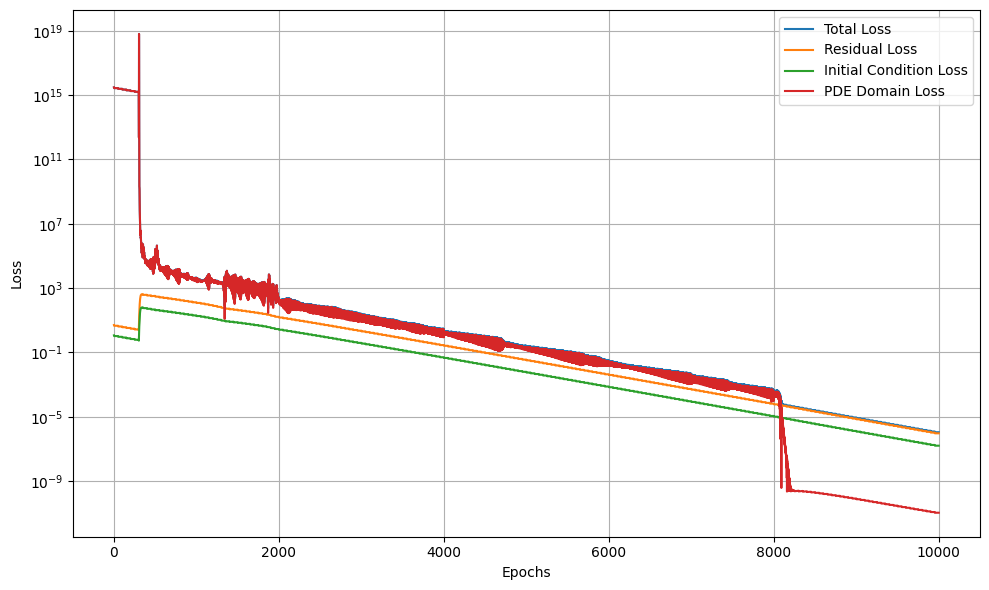

In [88]:
total_loss, loss_IC, loss_PDE, loss_residual = model.get_training_history() 

plt.figure(figsize=(10, 6))
plt.plot(total_loss, label='Total Loss')
plt.plot(loss_residual, label='Residual Loss')
plt.plot(loss_IC, label='Initial Condition Loss')
plt.plot(loss_PDE, label='PDE Domain Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
# Get model predictions after training
y_pred = model.network_prediction(t_valid, x_valid).float().detach().to(device).numpy()

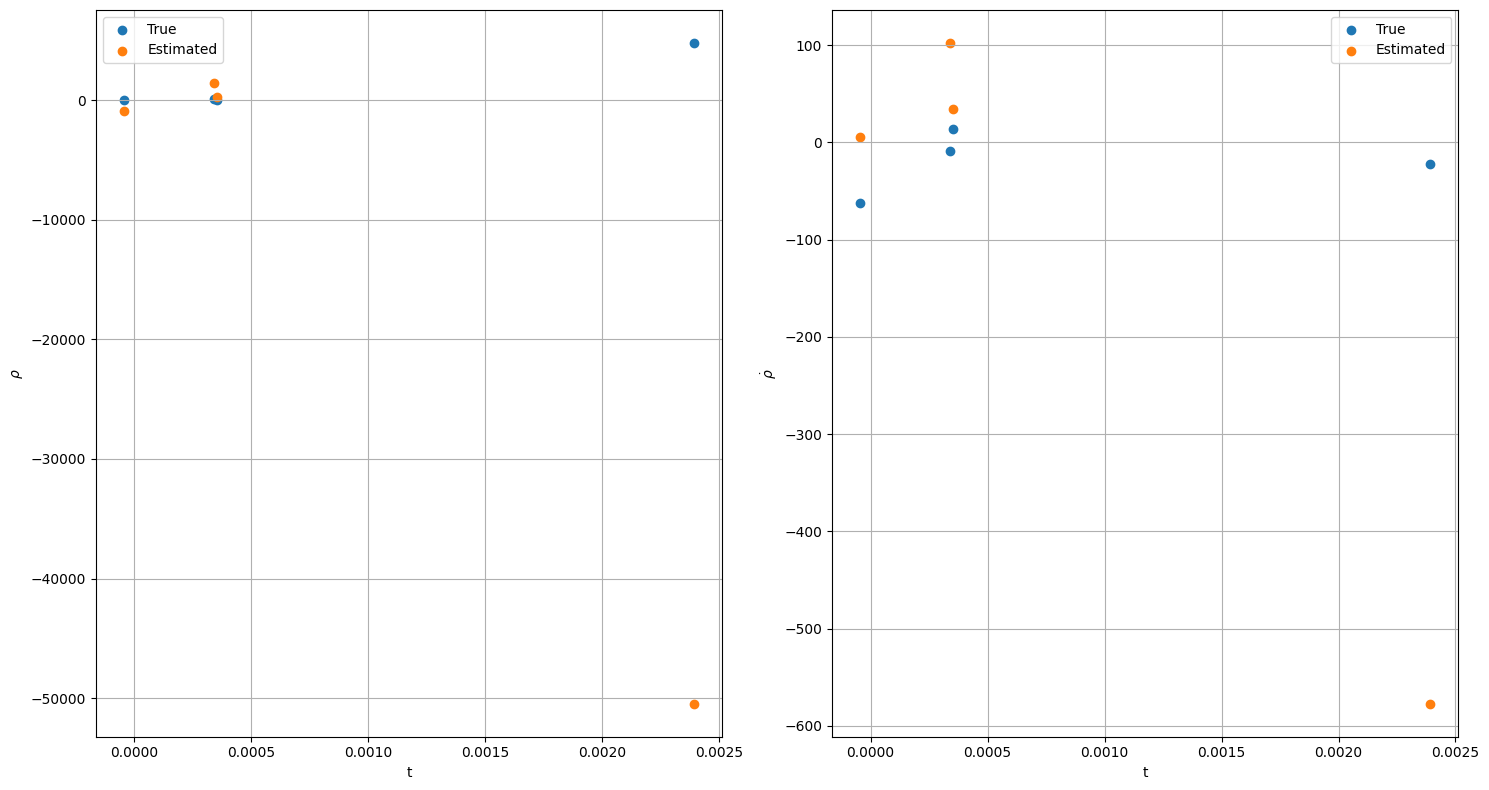

In [90]:
t_valid = denormalize(t_valid, t_valid_mins, t_valid_maxs)
x_valid = denormalize(x_valid, x_valid_mins, x_valid_maxs)
y_true_valid = denormalize(y_true_valid, y_true_valid_mins, y_true_valid_maxs)
y_pred = denormalize(torch.tensor(y_pred), y_true_valid_mins, y_true_valid_maxs)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].scatter(t_valid.float().detach().to(device).numpy(), y_true_valid[:,0].float().detach().to(device).numpy(), label = 'True')
axes[0].scatter(t_valid.float().detach().to(device).numpy(), y_pred[:,0], label = 'Estimated')
axes[0].set_xlabel('t')
axes[0].set_ylabel(r'$\rho$')
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(t_valid.float().detach().to(device).numpy(), y_true_valid[:,1].float().detach().to(device).numpy(), label = 'True')
axes[1].scatter(t_valid.float().detach().to(device).numpy(), y_pred[:,1], label = 'Estimated')
axes[1].set_xlabel('t')
axes[1].set_ylabel(r'$\dot{\rho}$')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()